In [4]:
! if [ -f 'TwoDimensionQW.py' ]; then rm TwoDimensionQW.py; else echo "file does not exits"; fi

file does not exits


In [5]:
from google.colab import files

files.upload();

Saving TwoDimensionQW.py to TwoDimensionQW.py


In [6]:
! if [ ! -d 'Images/' ]; then mkdir Images; fi
! ls -la

total 24
drwxr-xr-x 1 root root 4096 May  7 13:58 .
drwxr-xr-x 1 root root 4096 May  7 13:57 ..
drwxr-xr-x 4 root root 4096 May  5 13:39 .config
drwxr-xr-x 2 root root 4096 May  7 13:58 Images
drwxr-xr-x 1 root root 4096 May  5 13:40 sample_data
-rw-r--r-- 1 root root 2798 May  7 13:58 TwoDimensionQW.py


In [7]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [9]:
import seaborn as sns
sns.set(style="darkgrid")

In [10]:
from TwoDimensionQW import *

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"currently used device : {device}")

currently used device : cuda


In [12]:
plt.rc('font', family='serif')

<h1>2 Dimensional QW</h1>

In [10]:
class Simple2DWalk_IS(SimpleWalk2D):
    def Initial_state(self, **kwargs):
        st = torch.zeros(size = (self.dy,self.dx), dtype = torch.complex64)
        x0, y0 = kwargs.get("x0",self.dx //2), kwargs.get("y0", self.dy // 2)
        st[x0 % self.dx, y0 % self.dy] = 1
        st = st.unsqueeze(2).to(self.device)

        a = kwargs.get("a",1)
        b = kwargs.get("b",1j)

        cs = torch.tensor([a,b],dtype = torch.complex64)
        cs /= np.sqrt((cs * cs.conj()).sum())
        cs = cs.unsqueeze(0).unsqueeze(0).to(self.device)
        return st * cs

In [11]:
dimx, dimy = 81,81

x_coin_dict = {
    "th" : np.pi/2
}
y_coin_dict = {
    "th" : np.pi/2
}
init_state_dict = {
    "a" : 1,
    "b" : 1j
}

model = Simple2DWalk_IS(dimx,dimy,x_coin_dict,y_coin_dict,init_state_dict,device = device)

<ipython-input-10-8800876b83b7>:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cs /= np.sqrt((cs * cs.conj()).sum())


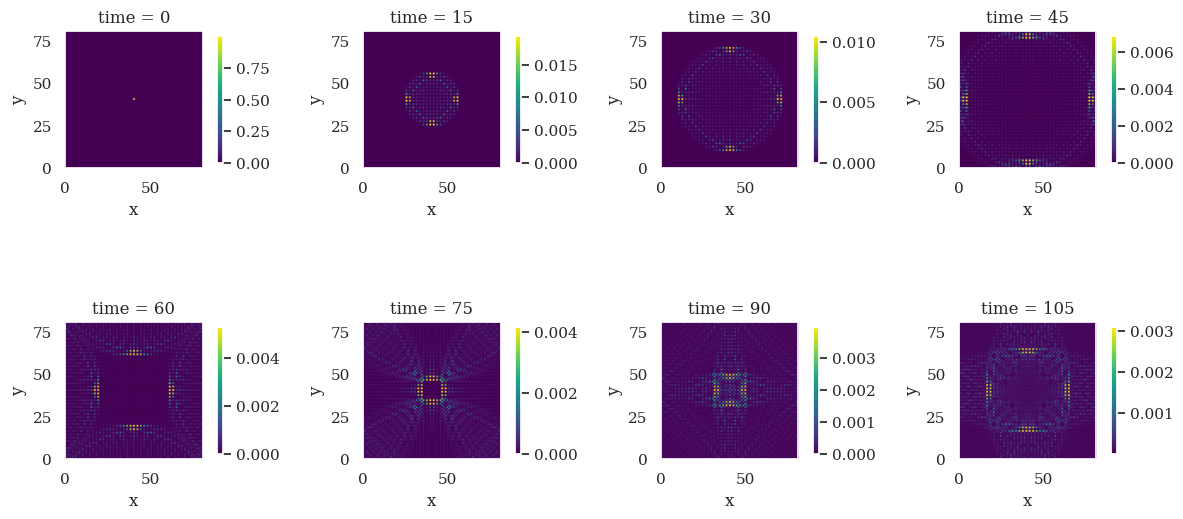

In [12]:
fig = plt.figure(figsize = (12,6))

time = 0
step = 15
prob = model.Get_prob()
num = 8

for i in range(num):
  ax = fig.add_subplot(num // 4, 4 ,i+1)
  im = ax.imshow(prob,origin = "lower",extent = [0,dimx,0,dimy], cmap = "viridis")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title(f"time = {time}")
  plt.colorbar(im, ax = ax, fraction=0.04, pad=0.09)
  plt.grid(False)

  for _ in range(step):
    model.Evolve()
    prob = model.Get_prob()
    time += 1

plt.tight_layout()

fig.savefig("Images/2DimQW.pdf",format= "pdf",bbox_inches = "tight")

In [ ]:
class MagneticWalk_IS(MagneticWalk):
    def Initial_state(self, **kwargs):
        X_ = torch.arange(self.dx)
        Y_ = torch.arange(self.dy)
        Y_,X_ = torch.meshgrid(X_,Y_)

        x0, y0 = kwargs.get("x0",self.dx //2), kwargs.get("y0", self.dy // 2)
        sigma = kwargs.get("sigma", 15)
        kx0 = kwargs.get("kx_0", 0.1 * np.pi)
        ky0 = kwargs.get("ky_0", 0.1 * np.pi)
        st = np.exp( -((X_ - x0)**2 + (Y_ - y0)**2) / (2*sigma ** 2) ) * np.exp( - 1j * ( X_ * kx0 + Y_ * ky0 ))
        st /= torch.sqrt( (st * st.conj()).sum() )
        st = st.unsqueeze(2).to(self.device)

        a = kwargs.get("a",1)
        b = kwargs.get("b",1j)

        cs = torch.tensor([a,b],dtype = torch.complex64)
        cs /= np.sqrt((cs * cs.conj()).sum())
        cs = cs.unsqueeze(0).unsqueeze(0).to(self.device)
        return st * cs

In [14]:
dimx, dimy = 600,600

x_coin_dict = {
    "th" : np.pi/2
}
y_coin_dict = {
    "th" : np.pi/2
}
init_state_dict = {
    "a" : 1,
    "b" : 0,
    "x0" : dimx // 4,
    "y0" : dimy // 2,
    "sigma" : 15,
    "kx_0" : np.pi/2 + np.pi/4,
    "ky_0" : -np.pi/2 + np.pi/4
}

B = 2 * np.pi / 1200

model = MagneticWalk_IS(dimx,dimy,x_coin_dict,y_coin_dict,init_state_dict,B, device = device)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-13-02822fcc302b>:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cs /= np.sqrt((cs * cs.conj()).sum())


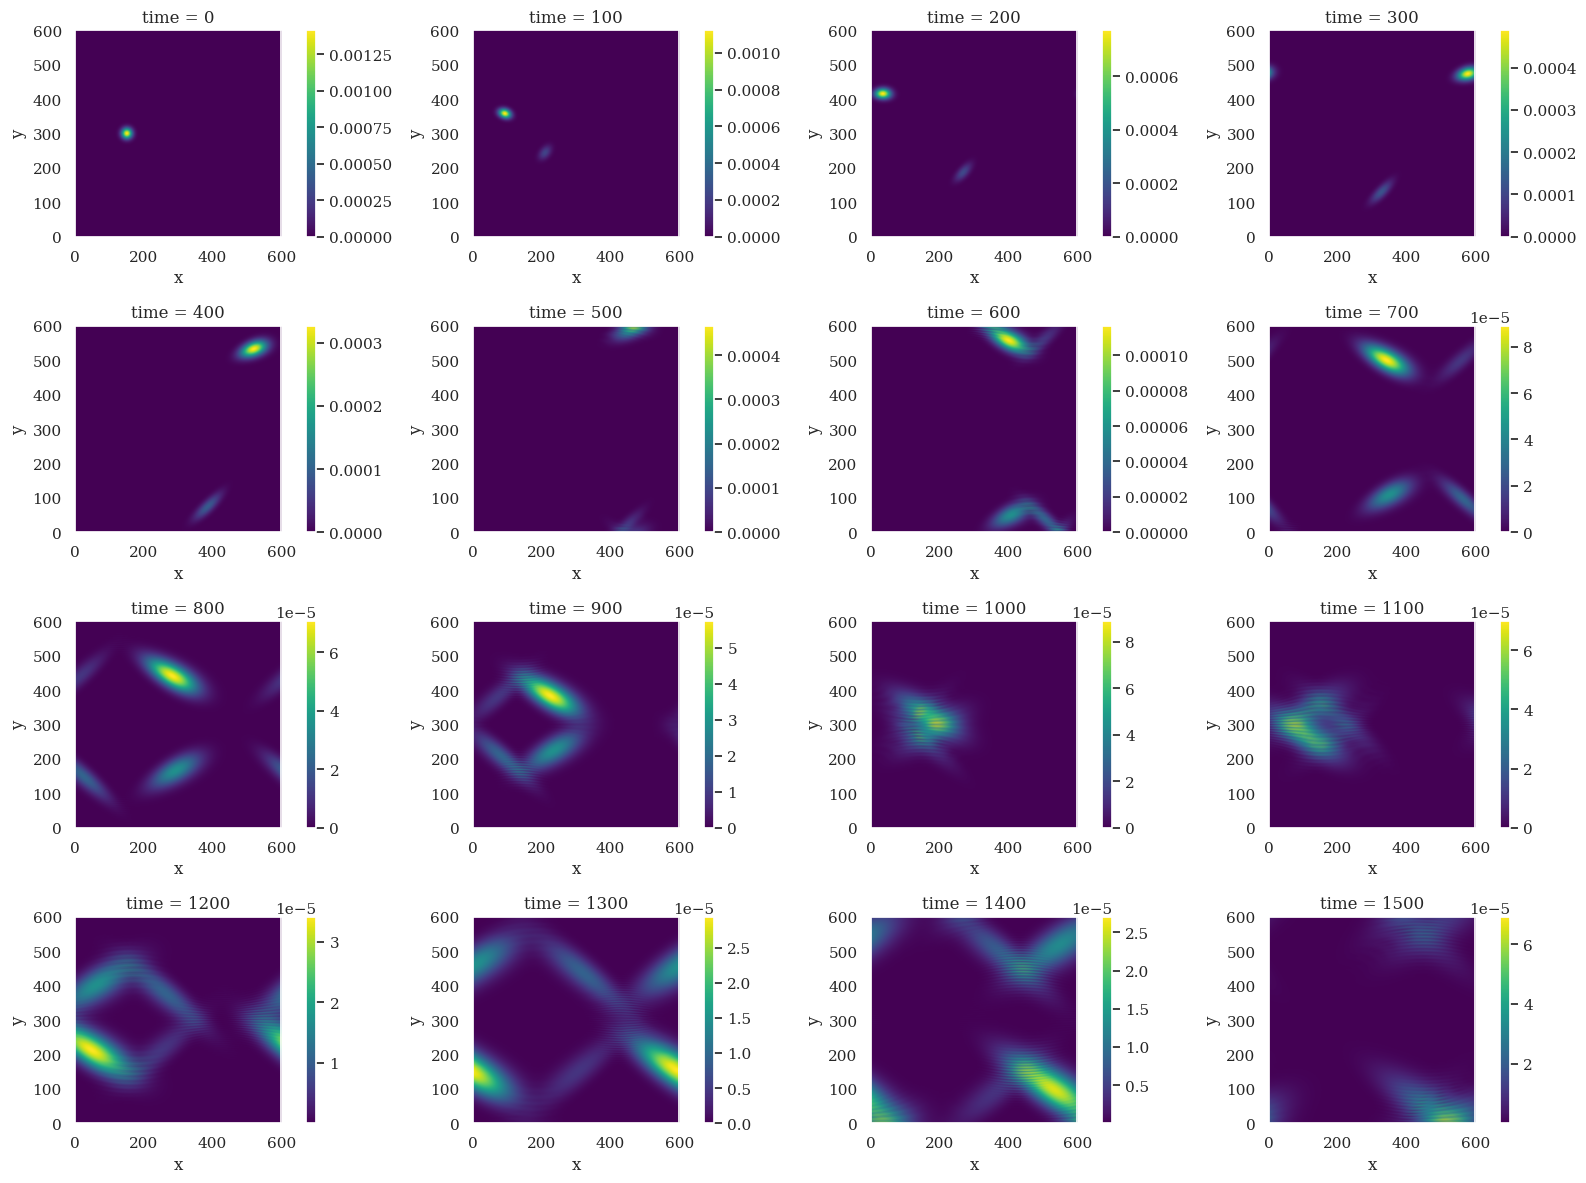

In [15]:
fig = plt.figure(figsize = (16,12))

time = 0
step = 100
prob = model.Get_prob()
num = 16

for i in range(num):
  ax = fig.add_subplot(num // 4, 4 ,i+1)
  im = ax.imshow(prob,origin = "lower",extent = [0,dimx,0,dimy], cmap = "viridis")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title(f"time = {time}")
  plt.colorbar(im, ax = ax, fraction=0.04, pad=0.09)
  plt.grid(False)

  for _ in range(step):
    model.Evolve()
    time += 1
  prob = model.Get_prob()

plt.tight_layout()

fig.savefig("Images/Magnetic2DimQW.pdf",format= "pdf",bbox_inches = "tight")

# Eigenspectrum

In [61]:
dim = 30
thx = np.pi/2
thy = np.pi/2
k_list = (np.arange(dim) - dim // 2 ) * 2 * np.pi / dim
B_list = np.arange(0,2 * np.pi,0.01)
B = 0.01

S = lambda k : torch.tensor([
    [np.exp(-1j * k), 0],
    [0, np.exp(1j * k) ]
])

F  = lambda B : torch.diag(
    torch.tensor([np.exp((-1)**(i+1) * 1j * B * (i//2)) for i in range(2 * dim)])
    ).to(torch.complex64)

C = lambda th : torch.tensor([
    [np.cos(th/2), -np.sin(th/2)],
    [np.sin(th/2), np.cos(th/2)]
])

Sx = torch.kron( torch.eye(dim).roll(-1,0), torch.tensor([[1,0],[0,0]]) ) + torch.kron( torch.eye(dim).roll(1,0), torch.tensor([[0,0],[0,1]]) ).to(torch.complex64)
Cy = torch.kron( torch.eye(dim), C(thy) ).to(torch.complex64)
Cx = torch.kron( torch.eye(dim), C(thx) ).to(torch.complex64)

for j,b_ in enumerate(B_list):
  Fe = F(b_)
  for i,k_ in enumerate(k_list):
    Sy = torch.kron( torch.eye(dim), S(k_)).to(torch.complex64)
    U = Fe @ Sy @ Cy @ Sx @ Cx
    E = torch.linalg.eigvals(U)
    E = -1j * torch.log(E)
    E = torch.sort(torch.abs(E)).values
    E[::2] *= -1
    Specter = E.reshape(-1,1) if i == 0 else torch.concat((Specter, E.reshape(-1,1)),dim = 1)
  E_total = Specter.reshape(-1,1) if j == 0 else torch.concat((E_total, Specter.reshape(-1,1)),dim = 1)




Text(0, 0.5, 'E')

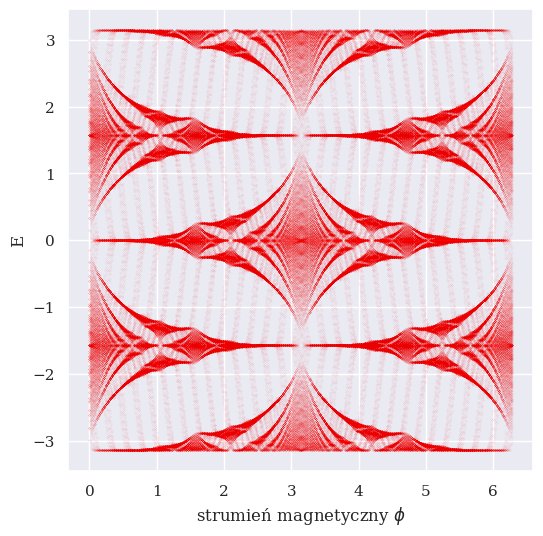

In [62]:
m,n = E_total.shape

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)

for i in range(m):
  ax.scatter(B_list, E_total[i,:], color = "red", s = 0.0001)

ax.set_xlabel("strumień magnetyczny " + r"$\phi$")
ax.set_ylabel("E")

In [75]:
dim = 30
thx = np.pi/2
thy = np.pi/2
k_list = (np.arange(dim) - dim // 2 ) * 2 * np.pi / dim
B_list = np.arange(0,2 * np.pi,0.01)
B = 0.01

S = lambda k : torch.tensor([
    [np.exp(-1j * k), 0],
    [0, np.exp(1j * k) ]
])

F  = lambda B : torch.diag(
    torch.tensor([np.exp((-1)**(i+1) * 1j * B * (i//2)) for i in range(2 * dim)])
    ).to(torch.complex64)

C = lambda th : torch.tensor([
    [np.cos(th/2), -np.sin(th/2)],
    [np.sin(th/2), np.cos(th/2)]
])

G = lambda beta : torch.tensor([
    [np.exp(beta), 0 ],
    [0, np.exp(-beta)]
])

Sx = torch.kron( torch.eye(dim).roll(-1,0), torch.tensor([[1,0],[0,0]]) ) + torch.kron( torch.eye(dim).roll(1,0), torch.tensor([[0,0],[0,1]]) ).to(torch.complex64)
Cy = torch.kron( torch.eye(dim), C(thy) ).to(torch.complex64)
Cx = torch.kron( torch.eye(dim), C(thx) ).to(torch.complex64)

gam = [0.0,0.01,0.1,0.5,1,1.5,2]

for k,g_ in enumerate(gam):
  Ge = torch.kron(torch.eye(dim), G(g_)).to(torch.complex64)
  for j,b_ in enumerate(B_list):
    Fe = F(b_)
    for i,k_ in enumerate(k_list):
      Sy = torch.kron( torch.eye(dim), S(k_)).to(torch.complex64)
      U = Fe @ Sy @ Cy @ Sx @ Cx @ Ge
      E = torch.linalg.eigvals(U)
      E = -1j * torch.log(E)
      E_real = torch.sort(torch.abs(E.real)).values
      E_imag = torch.sort(torch.abs(E.imag)).values
      E_real[::2] *= -1
      E_imag[::2] *= -1
      E = E_real + 1j * E_imag
      Specter = E.reshape(-1,1) if i == 0 else torch.concat((Specter, E.reshape(-1,1)),dim = 1)
    E_total = Specter.reshape(-1,1) if j == 0 else torch.concat((E_total, Specter.reshape(-1,1)),dim = 1)
  E_ans = E_total.unsqueeze(2) if k == 0 else torch.concat((E_ans,E_total.unsqueeze(2)), dim = 2)





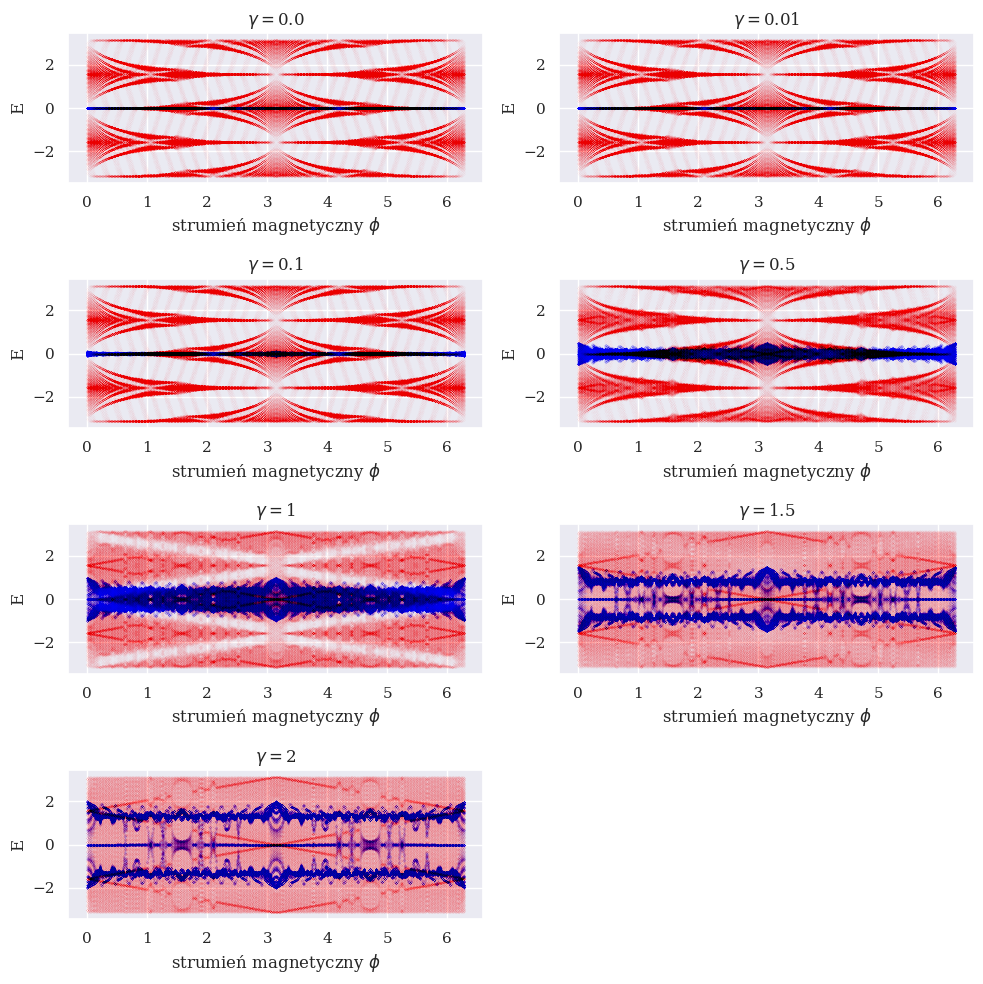

In [ ]:
m,n,k = E_ans.shape

fig = plt.figure(figsize = (10,18))

for s, g_ in enumerate(gam):
  ax = fig.add_subplot(4,2,s+1)

  for i in range(m):
    ax.scatter(B_list, E_ans[i,:,s].real, color = "red", s = 0.0001, alpha = 0.3)
    ax.scatter(B_list, E_ans[i,:,s].imag, color = "blue", s = 0.0001, alpha = 0.3)
  ax.set_title(r"$\gamma=$" + str(np.round(g_, 2)))
  ax.set_xlabel("strumień magnetyczny " + r"$\phi$")
  ax.set_ylabel("E")

plt.tight_layout()
plt.show()